In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
def oracle(qc, nodes_qubits, edge_anc):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0] ], nodes_qubits[edges[i][1] ], edge_anc[0]], edge_anc[1])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        
def reverse_oracle(qc, nodes_qubits, edge_anc):
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1])
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])

In [16]:
# PROBLEMS:
n_nodes = 4
edges = [(0, 1), (0, 2), (1, 2), (2, 3)]

# n_nodes = 4
# edges = [(0, 2), (1, 2), (2, 3)]

# n_nodes = 5
# edges = [(0, 2), (1, 2), (2, 3), (3, 4)]

# n_nodes = 5
# edges = [(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)]

# n_nodes = 6
# edges = [(1, 2), (0, 2), (2, 3), (1, 4), (0, 4), (4, 5), (1, 3)]

# n_nodes = 4
# edges = [(0, 1), (1, 2), (2, 3)]

# 7
n_nodes = 6
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 3), (0, 4)]

# 8 
n_nodes = 4
edges = [(0, 1), (1, 2), (2, 3)]

# 9
n_nodes = 7
edges = [(0, 1), (1, 2), (1, 4), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6)]

In [17]:
# all the combinations of 0 and 1 of size n_nodes
lst = list(itertools.product([0, 1], repeat=n_nodes))
# the combinations where sum = 4 (number of nodes in a claw)
sum_four_tuples = [a for a in lst if sum(a) == 4]
# convert int tuple to string
sum_four_states = [''.join(map(str, a)) for a in sum_four_tuples]
len(sum_four_states), sum_four_states

(35,
 ['0001111',
  '0010111',
  '0011011',
  '0011101',
  '0011110',
  '0100111',
  '0101011',
  '0101101',
  '0101110',
  '0110011',
  '0110101',
  '0110110',
  '0111001',
  '0111010',
  '0111100',
  '1000111',
  '1001011',
  '1001101',
  '1001110',
  '1010011',
  '1010101',
  '1010110',
  '1011001',
  '1011010',
  '1011100',
  '1100011',
  '1100101',
  '1100110',
  '1101001',
  '1101010',
  '1101100',
  '1110001',
  '1110010',
  '1110100',
  '1111000'])

In [31]:
def grover():
    node_qubits = QuantumRegister(n_nodes, name='n')
    vertex_flag = QuantumRegister(1, name='is_four_ones')
    e_qubits = QuantumRegister(2, name='e')
    flag_qubit = QuantumRegister(1, name="flag")
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    qc = QuantumCircuit(node_qubits, vertex_flag, e_qubits, flag_qubit, class_bits)
    # Initialize qunatum flag qubits in |-> state. i.e. qc.initialize([1, -1]/np.sqrt(2), flag_qubit)
    qc.x(flag_qubit)
    qc.h(flag_qubit)
    
    # Initializing i/p qubits in superposition
    qc.h(node_qubits)
    qc.barrier()

    num_iterations = 3
    for i in range(num_iterations):
        # 1
        for sum_four_state in sum_four_states:
            qc.append(MCXGate(n_nodes, ctrl_state=sum_four_state), node_qubits[:] + vertex_flag[:])
        
        # 2
        oracle(qc, node_qubits, e_qubits)

        qc.mct([vertex_flag, e_qubits[0], e_qubits[1]], flag_qubit)    

        # 2 reverse
        reverse_oracle(qc, node_qubits, e_qubits)
        
        # 1 reverse
        for sum_four_state in sum_four_states[::-1]:
            qc.append(MCXGate(n_nodes, ctrl_state=sum_four_state), node_qubits[:] + vertex_flag[:])    

        qc.barrier()
        qc.append(diffuser(n_nodes), node_qubits)
    
    qc.measure(node_qubits,class_bits)
    return qc

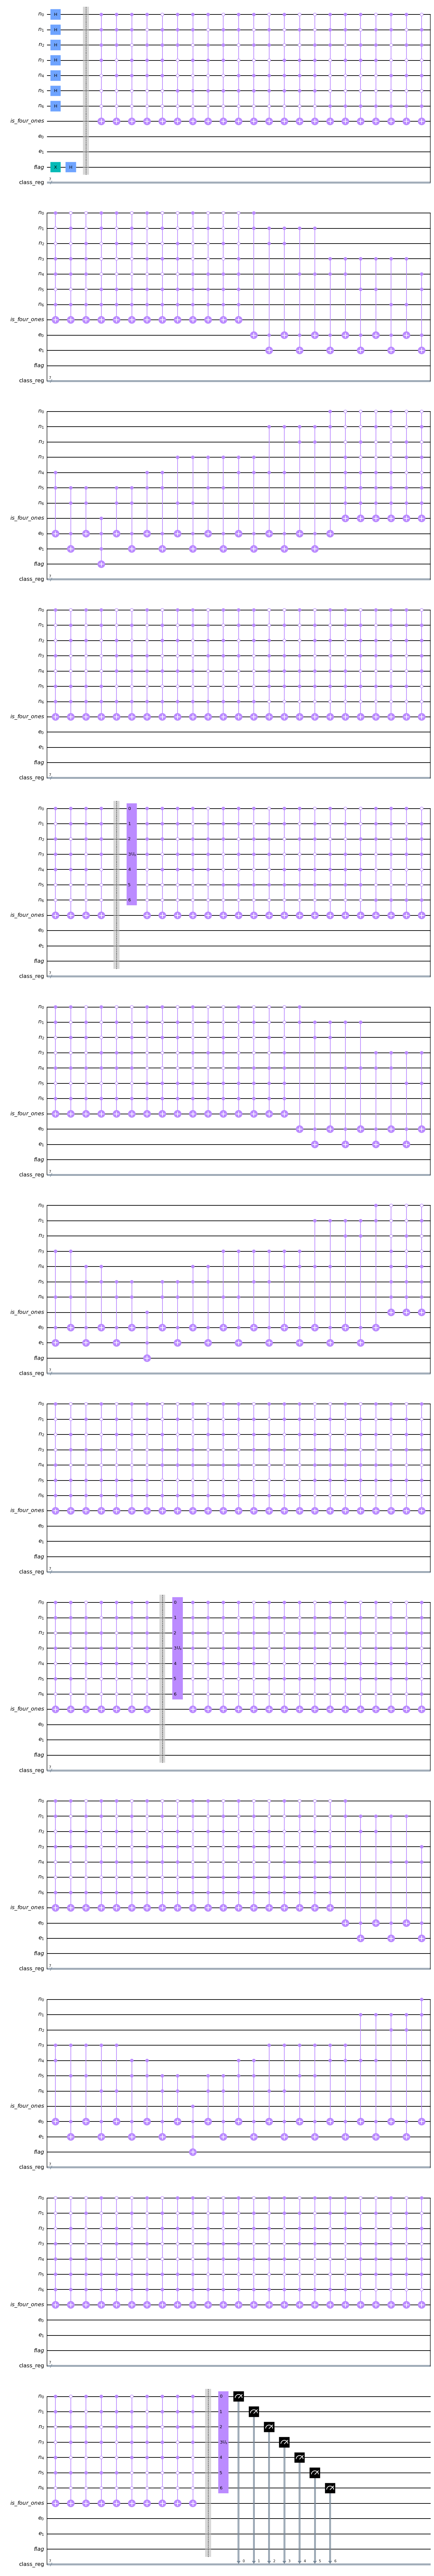

In [32]:
qc = grover()
qc.draw()

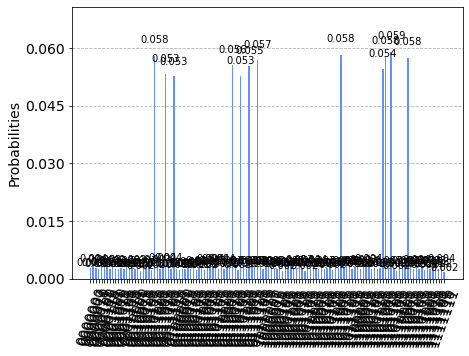

In [33]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=10000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [34]:
counts

{'0000111': 24,
 '1011101': 29,
 '1110110': 24,
 '0111110': 26,
 '0001101': 31,
 '0111101': 29,
 '0110100': 28,
 '1111010': 25,
 '0101001': 22,
 '0000011': 26,
 '1010001': 27,
 '0010000': 26,
 '1010100': 26,
 '1100100': 38,
 '1101111': 27,
 '1100010': 34,
 '0011100': 40,
 '0001010': 24,
 '0000001': 36,
 '0011001': 26,
 '0110010': 31,
 '0010101': 27,
 '0000000': 28,
 '0100101': 30,
 '1010110': 28,
 '0101111': 36,
 '0011111': 25,
 '1100000': 32,
 '1010010': 24,
 '0101101': 36,
 '1111101': 24,
 '1111110': 38,
 '0001011': 28,
 '1100011': 30,
 '1011110': 24,
 '1001000': 33,
 '0100110': 22,
 '1011111': 29,
 '0001001': 24,
 '1110010': 575,
 '1001100': 27,
 '1100101': 26,
 '1110101': 35,
 '1000100': 29,
 '1000110': 28,
 '1100110': 27,
 '0101100': 32,
 '1001110': 33,
 '1000011': 25,
 '0010001': 26,
 '0000100': 34,
 '0001110': 24,
 '0110101': 23,
 '1000001': 33,
 '0100011': 27,
 '0010111': 579,
 '1000101': 20,
 '0011011': 532,
 '0110110': 527,
 '1010000': 35,
 '1110111': 31,
 '0011110': 526,
 '1